In [14]:
from __future__ import annotations

import math
import random
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate, RYGate, HGate, CXGate, QFT
from qiskit.circuit.library import RXGate, PhaseGate
from qiskit.quantum_info import Operator
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService

from qiskit_aer.noise import NoiseModel
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

from qiskit.visualization import plot_histogram



from dataclasses import dataclass
from typing import List, Tuple
from scipy.sparse import csr_matrix, diags, identity, lil_matrix

from math import cos,sin, pi, e, asin, log, factorial

from qiskit.quantum_info import state_fidelity, hellinger_fidelity

import matplotlib.pyplot as plt

In [15]:
# ============================================================
# 1) Gerar H d-esparso com d = log2(N) = n, pesos inteiros positivos
# ============================================================

def desired_degree(N: int) -> int:
    """d = log2(N), saturated to N-1."""
    if N <= 1 or (N & (N - 1)) != 0:
        raise ValueError("N must be a power of 2 (e.g., 4, 8, 16).")
    d = int(np.log2(N))-1
    return min(d, N - 1)

def edges_complete_graph(n: int):
    """Edges of K_n as undirected pairs (i<j)."""
    return [(i, j) for i in range(n) for j in range(i+1, n)]

def edges_k_regular(n: int, k: int, seed: int = 0, max_tries: int = 20000):
    """
    Generate edges of a simple undirected k-regular graph (configuration model with rejection).
    Returns list of undirected edges (i<j).
    Requirements: n*k even.
    """
    if k < 0 or k >= n:
        raise ValueError("Require 0 <= k < n.")
    if (n * k) % 2 != 0:
        raise ValueError("Require n*k even for k-regular graph.")
    rng = np.random.default_rng(seed)

    for _ in range(max_tries):
        stubs = np.repeat(np.arange(n), k)
        rng.shuffle(stubs)

        seen = set()
        edges = []
        ok = True

        for i in range(0, len(stubs), 2):
            u = int(stubs[i]); v = int(stubs[i+1])
            if u == v:
                ok = False; break
            a, b = (u, v) if u < v else (v, u)
            if (a, b) in seen:
                ok = False; break
            seen.add((a, b))
            edges.append((a, b))

        if ok:
            return edges

    raise RuntimeError("Failed to generate a simple k-regular graph. Try another seed or increase max_tries.")

def dd_spd_matrix_from_edges(
    n: int,
    edges,
    w_min: int,
    w_max: int,
    s_min: int,
    s_max: int,
    seed: int
) -> csr_matrix:
    """
    Build symmetric positive integer matrix:
      A_ij = A_ji = w_ij for edges (i,j)
      A_ii = sum_{j!=i} A_ij + s_i   (strict diagonal dominance -> SPD)
    """
    rng = np.random.default_rng(seed)

    rows, cols, data = [], [], []
    for (i, j) in edges:
        w = int(rng.integers(w_min, w_max + 1))
        rows += [i, j]
        cols += [j, i]
        data += [w, w]

    W = csr_matrix((np.array(data, dtype=np.int64), (rows, cols)), shape=(n, n), dtype=np.int64)

    r = np.array(W.sum(axis=1)).reshape(-1).astype(np.int64)  # off-diagonal row sums
    s = rng.integers(s_min, s_max + 1, size=n, dtype=np.int64)

    A = W.copy()
    A.setdiag(r + s)
    A.eliminate_zeros()

    # Hermitian check (real symmetric)
    if (A != A.T).nnz != 0:
        raise AssertionError("Not symmetric (Hermitian).")

    return A

def generate_dd_spd_positive_integer_matrix(
    N: int,
    w_min: int = 1,
    w_max: int = 2,
    s_min: int = 4,
    s_max: int = 6,
    seed: int = 0
):
    """
    Main generator:
      - chooses d = log2(N)
      - constructs a simple d-regular graph (exact degree)
      - builds Hermitian SPD matrix with positive integer entries
    Returns: (A, d)
    """
    d = desired_degree(N)

    # If d == N-1, use complete graph (always possible)
    if d == N - 1:
        edges = edges_complete_graph(N)
    else:
        edges = edges_k_regular(N, d, seed=seed)

    A = dd_spd_matrix_from_edges(
        n=N, edges=edges,
        w_min=w_min, w_max=w_max,
        s_min=s_min, s_max=s_max,
        seed=seed
    )
    return A, d

# -----------------------------
# Demo: N = 4, 8, 16 (d = 2, 3, 4)
# -----------------------------



@dataclass(frozen=True)
class DSparseInstance:
    n: int
    d: int
    H: np.ndarray
    edges: List[Tuple[int, int]]
    diag: np.ndarray
    w_max_effective: int  # útil p/ definir quantos bits m usar no Oh

def generate_d_sparse_hamiltonian(
    n: int,
    seed: int = 0,
    w_max: int = 2,
    include_diag: bool = True,
    # parâmetros do seu gerador SPD:
    w_min: int = 1,
    s_min: int = 4,
    s_max: int = 6,
):
    """
    Versão integrada: usa seu gerador dd-SPD (dominância diagonal estrita),
    devolvendo no mesmo formato do pipeline.

    Observações:
      - include_diag deve ser True para SPD (diagonal sempre existe).
      - d vem da sua desired_degree(N) (log2(N)-1 saturado).
      - w_max_effective pode ser bem maior que w_max porque diag = sum(offdiag)+s.
    """
    if not include_diag:
        raise ValueError("Para SPD por dominância diagonal, include_diag deve ser True.")

    N = 2**n

    # --- chama seu gerador ---
    A_csr, d = generate_dd_spd_positive_integer_matrix(
        N=N,
        w_min=w_min, w_max=w_max,
        s_min=s_min, s_max=s_max,
        seed=seed
    )

    # csr -> denso (float) para seu expm_iHt etc.
    H = A_csr.toarray().astype(float)

    # extrair diagonal
    diag = np.diag(H).copy()

    # extrair edges offdiag (i<j)
    edges = []
    for i in range(N):
        for j in range(i + 1, N):
            if H[i, j] != 0:
                edges.append((i, j))

    # útil para dimensionar registrador h no Oh:
    # offdiag <= w_max, mas diag pode ser até d*w_max + s_max
    w_max_effective = int(np.max(H))

    return DSparseInstance(
        n=n, d=int(d), H=H, edges=edges, diag=diag,
        w_max_effective=w_max_effective
    )



# ============================================================
# 2) Coloração de arestas (matching por cor) — objeto que o Berry precisa
#    (para matriz explícita: coloração gulosa é suficiente p/ validar)
# ============================================================

def greedy_edge_coloring(N: int, edges: List[Tuple[int, int]]) -> Tuple[Dict[Tuple[int,int], int], int]:
    used_at = [set() for _ in range(N)]
    edge_color: Dict[Tuple[int,int], int] = {}
    maxc = -1
    for (u, v) in edges:
        c = 0
        while c in used_at[u] or c in used_at[v]:
            c += 1
        edge_color[(u, v)] = c
        used_at[u].add(c)
        used_at[v].add(c)
        maxc = max(maxc, c)
    return edge_color, maxc + 1


# ============================================================
# 3) Construir termos 1-esparsos (cada cor -> um matching)
#    + termo diagonal separado
# ============================================================

@dataclass(frozen=True)
class OneSparseTerm:
    n: int
    f: Dict[int, int]                      # involução (fixpoints ok)
    w: Dict[Tuple[int, int], int]          # (min,max) ou (x,x) -> peso inteiro
    w_max: int                             

def build_terms_from_edge_coloring(inst: DSparseInstance, w_max: int) -> Tuple[List[OneSparseTerm], OneSparseTerm]:
    N = 2**inst.n
    edge_color, num_colors = greedy_edge_coloring(N, inst.edges)

    # montar, para cada cor, um matching parcial
    terms: List[OneSparseTerm] = []
    for c in range(num_colors):
        f = {x: x for x in range(N)}  # fixpoints default
        w: Dict[Tuple[int,int], int] = {}  # só edges desse termo
        for (u, v), col in edge_color.items():
            if col != c:
                continue
            f[u] = v
            f[v] = u
            w[(min(u, v), max(u, v))] = int(inst.H[u, v])
        terms.append(OneSparseTerm(n=inst.n, f=f, w=w, w_max=w_max))

    # termo diagonal separado (1-esparso também)
    fD = {x: x for x in range(N)}
    wD: Dict[Tuple[int,int], int] = {}
    for x in range(N):
        if inst.diag[x] != 0:
            wD[(x, x)] = int(inst.diag[x])
    diag_term = OneSparseTerm(n=inst.n, f=fD, w=wD, w_max=w_max)

    return terms, diag_term


# ============================================================
# 4) Oráculos por permutação: Of, Oh, Ogt, Oeq
# ============================================================

def make_perm_unitary(mapping: List[int]) -> np.ndarray:
    dim = len(mapping)
    U = np.zeros((dim, dim), dtype=complex)
    for i, j in enumerate(mapping):
        U[j, i] = 1.0
    return U

def build_Of_gate(n: int, f: Dict[int, int], label: str = "Of") -> UnitaryGate:
    N = 2**n
    dim = 2**(2*n)
    mapping = list(range(dim))
    for x in range(N):
        fx = f[x]
        for y in range(N):
            inp = x | (y << n)
            out = x | ((y ^ fx) << n)
            mapping[inp] = out
    return UnitaryGate(make_perm_unitary(mapping), label=label)

def build_Oh_gate(n: int, m: int, f: Dict[int, int], w: Dict[Tuple[int,int], int], label: str = "Oh") -> UnitaryGate:
    N = 2**n
    dim = 2**(2*n + m)
    Hdim = 2**m
    mapping = list(range(dim))
    for x in range(N):
        fx = f[x]
        for y in range(N):
            if y == fx:
                key = (min(x, y), max(x, y))
                hxy = int(w.get(key, 0))
            else:
                hxy = 0
            for hreg in range(Hdim):
                inp = x | (y << n) | (hreg << (2*n))
                out = x | (y << n) | ((hreg ^ hxy) << (2*n))
                mapping[inp] = out
    return UnitaryGate(make_perm_unitary(mapping), label=label)

def build_Ogt_gate(n: int, label: str = "Ogt") -> UnitaryGate:
    N = 2**n
    dim = 2**(2*n + 1)
    mapping = list(range(dim))
    for x in range(N):
        for y in range(N):
            gt = 1 if x > y else 0
            for b in (0, 1):
                inp = x | (y << n) | (b << (2*n))
                out = x | (y << n) | ((b ^ gt) << (2*n))
                mapping[inp] = out
    return UnitaryGate(make_perm_unitary(mapping), label=label)

def build_Oeq_gate(n: int, label: str = "Oeq") -> UnitaryGate:
    N = 2**n
    dim = 2**(2*n + 1)
    mapping = list(range(dim))
    for x in range(N):
        for y in range(N):
            eq = 1 if x == y else 0
            for e in (0, 1):
                inp = x | (y << n) | (e << (2*n))
                out = x | (y << n) | ((e ^ eq) << (2*n))
                mapping[inp] = out
    return UnitaryGate(make_perm_unitary(mapping), label=label)


# ============================================================
# 5) Simulador 1-esparso (com diagonal) via Of/Oh + rotações controladas
#    Retorna U_eff (NxN) atuando só no registro x.
# ============================================================

def build_one_sparse_circuit_with_diagonal(term: OneSparseTerm, t: float) -> Tuple[QuantumCircuit, int]:
    n = term.n
    w_max = term.w_max
    m = max(1, math.ceil(math.log2(w_max + 1)))

    x = QuantumRegister(n, "x")
    y = QuantumRegister(n, "y")
    hreg = QuantumRegister(m, "h")
    b = QuantumRegister(1, "b")      # também usado como qubit de mistura offdiag
    e = QuantumRegister(1, "e")      # flag x==y
    neq = QuantumRegister(1, "neq")  # NOT e
    p = QuantumRegister(1, "p")      # ancila de fase (kickback)

    qc = QuantumCircuit(x, y, hreg, b, e, neq, p)

    Of = build_Of_gate(n, term.f, "Of")
    Oh = build_Oh_gate(n, m, term.f, term.w, "Oh")
    Ogt = build_Ogt_gate(n, "Ogt")
    Oeq = build_Oeq_gate(n, "Oeq")

    # p = |1>
    qc.x(p[0])

    # y = f(x)
    qc.append(Of, list(x) + list(y))

    # b ^= [x>y]
    qc.append(Ogt, list(x) + list(y) + [b[0]])

    # se b=1 troca x<->y => x=min, y=max
    for k in range(n):
        qc.cswap(b[0], x[k], y[k])

    # e ^= [x==y]
    qc.append(Oeq, list(x) + list(y) + [e[0]])

    # neq = NOT e (neq começa em |0>)
    qc.x(neq[0])        # 1
    qc.cx(e[0], neq[0]) # se e=1 => neq=0

    # carrega h
    qc.append(Oh, list(x) + list(y) + list(hreg))

    # OFFDIAG: Rx(2*h*t) em b condicionado em (neq AND h_k)
    for k in range(m):
        angle = 2.0 * t * (2**k)
        crx2 = RXGate(angle).control(2)
        qc.append(crx2, [neq[0], hreg[k], b[0]])

    # DIAG: fase exp(-i*h*t) em p condicionado em (e AND h_k)
    for k in range(m):
        lam = -t * (2**k)
        cph2 = PhaseGate(lam).control(2)
        qc.append(cph2, [e[0], hreg[k], p[0]])

    # uncompute h
    qc.append(Oh.inverse(), list(x) + list(y) + list(hreg))

    # uncompute neq,e
    qc.cx(e[0], neq[0])
    qc.x(neq[0])
    qc.append(Oeq.inverse(), list(x) + list(y) + [e[0]])

    # desfaz canonização
    for k in range(n):
        qc.cswap(b[0], x[k], y[k])

    # desfaz b e y
    qc.append(Ogt.inverse(), list(x) + list(y) + [b[0]])
    qc.append(Of.inverse(), list(x) + list(y))

    # p volta a |0>
    qc.x(p[0])

    return qc, m

from qiskit.quantum_info import Statevector

def extract_U_eff_on_x_statevector(qc: QuantumCircuit, n: int, m: int) -> np.ndarray:
    """
    Extrai U_eff (N x N) usando simulação de Statevector:
      U_eff[:, xin] = projeção em ancillas=0 do estado final ao evoluir |xin, anc=0>.
    Layout: x(n), y(n), h(m), b, e, neq, p  => total = 2n+m+4
    """
    N = 2**n
    total = 2*n + m + 4
    dim = 2**total

    def idx(xv, yv, hv, bv, ev, nqv, pv):
        return (
            xv
            | (yv << n)
            | (hv << (2*n))
            | (bv << (2*n + m))
            | (ev << (2*n + m + 1))
            | (nqv << (2*n + m + 2))
            | (pv << (2*n + m + 3))
        )

    U_eff = np.zeros((N, N), dtype=complex)

    for xin in range(N):
        ket = np.zeros(dim, dtype=complex)
        ket[idx(xin, 0, 0, 0, 0, 0, 0)] = 1.0
        out = Statevector(ket).evolve(qc).data
        for xout in range(N):
            U_eff[xout, xin] = out[idx(xout, 0, 0, 0, 0, 0, 0)]

    return U_eff



# ============================================================
# 6) Exato, Trotter e erro
# ============================================================

def expm_iHt(H: np.ndarray, t: float) -> np.ndarray:
    evals, evecs = np.linalg.eigh(H)
    phases = np.exp(-1j * evals * t)
    return (evecs @ np.diag(phases) @ evecs.T).astype(complex)

def unitary_error(U_sim: np.ndarray, U_exact: np.ndarray) -> dict:
    D = U_sim - U_exact
    return {
        "frobenius": float(np.linalg.norm(D, ord="fro")),
        "spectral_2": float(np.linalg.norm(D, ord=2)),
    }

def trotter_first_order_from_terms_statevector(
    terms: List[OneSparseTerm],
    diag_term: OneSparseTerm,
    t: float,
    r: int,
) -> np.ndarray:
    """
    U ≈ ( U_diag(dt) * Π_j U_j(dt) )^r  (1ª ordem)
    mas extraindo U_j via Statevector (robusto).
    """
    n = diag_term.n
    N = 2**n
    dt = t / r

    # cache U de cada termo nesse dt
    cache: List[np.ndarray] = []

    # diagonal
    qcD, mD = build_one_sparse_circuit_with_diagonal(diag_term, dt)
    U_diag = extract_U_eff_on_x_statevector(qcD, n=n, m=mD)

    # termos offdiag
    for term in terms:
        qc, m = build_one_sparse_circuit_with_diagonal(term, dt)
        Uj = extract_U_eff_on_x_statevector(qc, n=n, m=m)
        cache.append(Uj)

    # monta U_step
    U_step = U_diag.copy()
    for Uj in cache:
        U_step = Uj @ U_step

    return np.linalg.matrix_power(U_step, r)


def strang_second_order_from_terms_statevector(
    terms: List[OneSparseTerm],
    diag_term: OneSparseTerm,
    t: float,
    r: int,
) -> np.ndarray:
    """
    Strang (2ª ordem) usando U_j extraído via Statevector.
    """
    n = diag_term.n
    N = 2**n
    dt = t / r
    half = dt / 2

    # U_diag(half)
    qcD, mD = build_one_sparse_circuit_with_diagonal(diag_term, half)
    U_diag_h = extract_U_eff_on_x_statevector(qcD, n=n, m=mD)

    # U_j(half) cache
    U_half = []
    for term in terms:
        qc, m = build_one_sparse_circuit_with_diagonal(term, half)
        Uj = extract_U_eff_on_x_statevector(qc, n=n, m=m)
        U_half.append(Uj)

    # monta um passo Strang
    U_step = U_diag_h.copy()
    for Uj in U_half:
        U_step = Uj @ U_step
    for Uj in reversed(U_half):
        U_step = Uj @ U_step
    U_step = U_diag_h @ U_step

    return np.linalg.matrix_power(U_step, r)


# ============================================================
# 7) Plotar Gráficos de erro vs r
# ============================================================

def plot_errors(err_t, err_s, r_list, cond, n):
    r_list = sorted(err_t.keys())
    rs = np.array(r_list, dtype=float)

    plt.figure(figsize=(8,5))
    plt.loglog(rs, [err_t[r] for r in r_list], 'o-', label='Trotter (1a ordem)')
    plt.loglog(rs, [err_s[r] for r in r_list], 's-', label='Strang (2a ordem)')

    C1 = err_t[r_list[0]] * rs[0]
    C2 = err_s[r_list[0]] * (rs[0]**2)

    plt.loglog(rs, C1/rs, '--', label='Ref ~ 1/r')
    plt.loglog(rs, C2/(rs**2), ':', label='Ref ~ 1/r^2')

    plt.xlabel('Trotter steps r')
    plt.ylabel('min_phi ||U_sim - e^{i phi} e^{-iHt}||_2')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.xticks(rs)
    plt.savefig(f'erro_trotter_strang_{cond}_N{2**n}.png')
    plt.show()
        



In [16]:
import math
from qiskit import QuantumCircuit, QuantumRegister

def build_trotter_first_order_circuit(
    terms, diag_term, t: float, r: int
) -> QuantumCircuit:
    """
    Retorna um QuantumCircuit que implementa:
      U ≈ ( U_diag(dt) * Π_j U_j(dt) )^r
    no espaço (x,y,h,b,e,neq,p). Ancillas são uncomputed ao final de cada bloco.
    """
    n = diag_term.n
    w_max = diag_term.w_max
    m = max(1, math.ceil(math.log2(w_max + 1)))
    dt = t / r

    # registradores globais (1x)
    x = QuantumRegister(n, "x")
    y = QuantumRegister(n, "y")
    h = QuantumRegister(m, "h")
    b = QuantumRegister(1, "b")
    e = QuantumRegister(1, "e")
    neq = QuantumRegister(1, "neq")
    p = QuantumRegister(1, "p")

    qc = QuantumCircuit(x, y, h, b, e, neq, p, name=f"U_trot_r{r}")

    def append_term(term, time):
        sub, m_sub = build_one_sparse_circuit_with_diagonal(term, time)
        if m_sub != m:
            raise ValueError(f"m mismatch: got {m_sub}, expected {m}. "
                             "Fixe m no build_one_sparse_circuit_with_diagonal.")
        qc.append(sub.to_gate(), [*x, *y, *h, b[0], e[0], neq[0], p[0]])

    # repete r passos
    for _ in range(r):
        append_term(diag_term, dt)
        for term in terms:
            append_term(term, dt)

    # print(qc.draw())
    return qc


def build_strang_second_order_circuit(
    terms, diag_term, t: float, r: int
) -> QuantumCircuit:
    """
    Retorna um QuantumCircuit que implementa Strang:
      U ≈ ( Udiag(h) Π Uj(h) Π Uj(h)rev Udiag(h) )^r  com h=dt/2
    """
    n = diag_term.n
    w_max = diag_term.w_max
    m = max(1, math.ceil(math.log2(w_max + 1)))
    dt = t / r
    half = dt / 2

    x = QuantumRegister(n, "x")
    y = QuantumRegister(n, "y")
    h = QuantumRegister(m, "h")
    b = QuantumRegister(1, "b")
    e = QuantumRegister(1, "e")
    neq = QuantumRegister(1, "neq")
    p = QuantumRegister(1, "p")

    qc = QuantumCircuit(x, y, h, b, e, neq, p, name=f"U_strang_r{r}")

    def append_term(term, time):
        sub, m_sub = build_one_sparse_circuit_with_diagonal(term, time)
        if m_sub != m:
            raise ValueError(f"m mismatch: got {m_sub}, expected {m}.")
        qc.append(sub.to_gate(), [*x, *y, *h, b[0], e[0], neq[0], p[0]])

    for _ in range(r):
        append_term(diag_term, half)
        for term in terms:
            append_term(term, half)
        for term in reversed(terms):
            append_term(term, half)
        append_term(diag_term, half)

    # print(qc.draw())
    return qc


def build_controlled_strang_step_blocks(terms, diag_term, t, r):
    """
    Retorna uma lista de ControlledGate que implementa UM PASSO de Strang (2ª ordem),
    com dt=t/r e half=dt/2:
      U_step = Udiag(half) Π Uj(half) Π Uj(half)rev Udiag(half)

    cada bloco é controlado individualmente (mais leve que controlar o mega-U).
    """
    dt = t / r
    half = dt / 2

    blocks = []

    # Diagonal half
    subD, _ = build_one_sparse_circuit_with_diagonal(diag_term, half)
    gD = subD.to_gate(label="Udiag_h")
    blocks.append(gD.control(1))

    # Forward
    for idx, term in enumerate(terms):
        sub, _ = build_one_sparse_circuit_with_diagonal(term, half)
        g = sub.to_gate(label=f"U{idx}_h")
        blocks.append(g.control(1))

    # Reverse
    for idx, term in enumerate(reversed(terms)):
        sub, _ = build_one_sparse_circuit_with_diagonal(term, half)
        g = sub.to_gate(label=f"Urev{idx}_h")
        blocks.append(g.control(1))


    blocks.append(gD.control(1))

    return blocks




## Aplicação do HHL

In [114]:

def get_classic_decomposition(A):
    w,v = np.linalg.eig(A)

    # print(w)
    # print(v)

    cols = A.shape[0]

    #
    A_lambda = []
    # print(A_lambda)
    for i in range(cols):
        A_lambda.append(round(w[i]/min(w)))

    A_lambda.sort()
    return v, w, A_lambda



def get_classic_U(v, w, t, precision):
    U_array = []

    cols = w.shape[0]

    U = np.zeros((cols, cols), dtype=complex)
    
    # print(U)

    for i in range(precision):
        if i ==0:
            for j in range(cols):
                # print(j)
                U[j, j] = e**(-1j*w[j]*t)
        else:
            U = np.dot(U, U)
        U_array.append(np.dot(np.dot(v.transpose(),U),v))


    # print(U_array)
    return U_array

def make_u(matrix,i=0, inverse=False):
    if inverse:
        # print("=========================== INÍCIO: prepara U inverso ==================================")
        u = Operator(np.linalg.inv(matrix))   # cria um operador da matriz invertida

        gate = UnitaryGate(u)  # cria porta unitária a partir do operador
        # print("=========================== FIM: prepara U inverso ==================================")
    else:
        # print("=========================== INÍCIO: prepara u ==================================")
        u = Operator(matrix)  # Cria um operador da matriz

        gate = UnitaryGate(u)    # cria porta unitária a partir do operador
        # print("=========================== INÍCIO: prepara U ==================================")
    return gate


def qpe(circuit, U_array, reg_clock, reg_b, precision, inverse=False):
    if inverse:
        # print("=========================== INÍCIO: QPE inverso ==================================")
        for i in range(precision):
            circuit.append(make_u(U_array[precision-i-1], precision-i-1, inverse=inverse).control(1), [reg_clock[i]] + [reg_b[j] for j in range(reg_b.size)])

        circuit.h(reg_clock)
        # print("=========================== FIM: QPE inverso ==================================")
    else:
        # print("=========================== INÍCIO: QPE ==================================")
        circuit.h(reg_clock)

        for i in range(precision):
            circuit.append(make_u(U_array[i], i).control(1), [reg_clock[i]] + [reg_b[j] for j in range(reg_b.size)])

        # print("=========================== FIM: QPE ==================================")


def rotacoes_controladas(circuit, reg_clock, reg_ancilla, lmb, precision):
    for i in lmb:
        # print("=========================== INÍCIO: rotações controladas ==================================")
        # print(f'lambda: {i}')
        # print(bin(i)[2:].zfill(precision))
        # if (len(bin(i)[2:]) > precision):
        #     raise Exception("""
        #     O número necessário de bits para representar autovalores excede o número de bits de precisão.
        #     Precisão: """ + """str(precision) """+
        #     """Registrador de clock: """ + str(len(bin(i)[2:])))
        circuit.append(RYGate(2*asin(1/i)).control(precision, ctrl_state=bin(i)[2:2+precision].zfill(precision)), [reg_clock[j] for j in range(precision)] + [reg_ancilla])
        # print("=========================== FIM: rotações controladas ==================================")


In [115]:

def hhl_generico(v, w, precision, t, n, lmb):

    reg_hhl_ancilla = QuantumRegister(1, name="ancilla")
    reg_hhl_clock = QuantumRegister(precision, name="clock")
    reg_hhl_b = QuantumRegister(n, name="b")
    reg_hhl_ancilla_classico = ClassicalRegister(1)
    reg_hhl_classico = ClassicalRegister(n)
    circuit_hhl = QuantumCircuit(reg_hhl_ancilla, reg_hhl_clock, reg_hhl_b, reg_hhl_ancilla_classico, reg_hhl_classico)

    circuit_hhl.h(reg_hhl_b)

    U_array = get_classic_U(v, w, t, precision)

    qpe(circuit_hhl, U_array, reg_hhl_clock, reg_hhl_b, precision)

    circuit_hhl.append(QFT(precision,inverse=True),reg_hhl_clock)

    rotacoes_controladas(circuit_hhl, reg_hhl_clock, reg_hhl_ancilla, lmb, precision)

    circuit_hhl.measure(reg_hhl_ancilla, reg_hhl_ancilla_classico)

    circuit_hhl.append(QFT(precision,inverse=False),reg_hhl_clock)

    qpe(circuit_hhl, U_array, reg_hhl_clock, reg_hhl_b, precision, inverse=True)

    circuit_hhl.measure(reg_hhl_b, reg_hhl_classico)

    circuit_hhl.draw()

    return circuit_hhl

In [104]:
def qpe_modificado(circuit, U, reg_clock, reg_b, reg_ancilla_sim, precision, order, inverse=False):

    gate = U.inverse() if inverse else U
    if inverse:
        for k in range(precision):
            reps = 2**k
            for _ in range(reps):
                circuit.append(gate, [reg_clock[i]] + [reg_b[j] for j in range(reg_b.size)] + [reg_ancilla_sim[k] for k in range(reg_ancilla_sim.size)])


        circuit.h(reg_clock)
    else:
        circuit.h(reg_clock)

        for i in range(precision):
            temp = 2**i
            for s in range(temp):
              circuit.append(gate, [reg_clock[i]] + [reg_b[j] for j in range(reg_b.size)] + [reg_ancilla_sim[k] for k in range(reg_ancilla_sim.size)])



def qpe_modificado(circuit, U_gate, reg_clock, reg_b, reg_ancilla_sim, precision, inverse=False):
    targets = [*reg_b, *reg_ancilla_sim]

    if not inverse:
        circuit.h(reg_clock)
        for i in range(precision):
            for _ in range(2**i):
                circuit.append(U_gate, [reg_clock[i], *targets])
    else:
        # desfaz em ordem reversa
        for i in reversed(range(precision)):
            for _ in range(2**i):
                circuit.append(U_gate, [reg_clock[i], *targets])
        circuit.h(reg_clock)



def qpe_with_blocks(circuit, blocks, reg_clock, targets, precision, inverse=False):
    if not inverse:
        circuit.h(reg_clock)
        for i in range(precision):
            for _ in range(2**i):
                for blk in blocks:
                    circuit.append(blk, [reg_clock[i], *targets])
    else:
        for i in reversed(range(precision)):
            for _ in range(2**i):
                # inverso do passo: aplica inversos em ordem reversa
                for blk in reversed(blocks):
                    circuit.append(blk.inverse(), [reg_clock[i], *targets])
        circuit.h(reg_clock)


def qpe_with_blocks(circuit, blocks_fwd, blocks_inv, reg_clock, targets, precision, inverse=False):
    if not inverse:
        circuit.h(reg_clock)
        for i in range(precision):
            for _ in range(2**i):
                for blk in blocks_fwd:
                    circuit.append(blk, [reg_clock[i], *targets])
    else:
        for i in reversed(range(precision)):
            for _ in range(2**i):
                for blk in blocks_inv:
                    circuit.append(blk, [reg_clock[i], *targets])
        circuit.h(reg_clock)




def qpe_with_powers(circ, cU_pows, reg_clock, reg_x, inverse=False, cUinv_pows=None):
    p = len(reg_clock)

    if not inverse:
        circ.h(reg_clock)
        for k in range(p):
            circ.append(cU_pows[k], [reg_clock[k], *reg_x])
    else:
        for k in reversed(range(p)):
            circ.append(cUinv_pows[k], [reg_clock[k], *reg_x])
        circ.h(reg_clock)



def precompute_controlled_powers(U_eff: np.ndarray, precision: int):
    """
    Retorna listas:
      cU[k]    = controlled(U_eff^(2^k))
      cUinv[k] = controlled((U_eff^(2^k))^\dagger)
    usando 'repeated squaring' (U <- U@U).
    """
    cU = []
    cUinv = []
    U = U_eff.astype(complex)

    for k in range(precision):
        g = UnitaryGate(U, label=f"U^{2**k}")
        cU.append(g.control(1))
        cUinv.append(g.inverse().control(1))
        U = U @ U
    return cU, cUinv


def qpe_fast(circuit, cU, cUinv, reg_clock, reg_b, precision, inverse=False):
    if not inverse:
        circuit.h(reg_clock)
        for i in range(precision):
            circuit.append(cU[i], [reg_clock[i]] + list(reg_b))
    else:
        for i in reversed(range(precision)):
            circuit.append(cUinv[i], [reg_clock[i]] + list(reg_b))
        circuit.h(reg_clock)




In [105]:
def hhl_unificado(A, U, U_inv, precision, t, n, r, terms, diag_term, lmb, order=1):

      w_max = diag_term.w_max
      m = max(1, math.ceil(math.log2(w_max + 1)))

      sim_anc_size = n + m + 4  # n (x) + n (y) + m (h) + 1 (b) + 1 (e) + 1 (neq) + 1 (p)

      reg_ancilla_hhl = QuantumRegister(1, name="ancilla HHL")
      reg_ancilla_sim = QuantumRegister(sim_anc_size, name="ancilla SIM")
      reg_clock = QuantumRegister(precision, name="clock")
      reg_b = QuantumRegister(n, name="b")
      reg_ancilla_classico = ClassicalRegister(1)
      reg_classico = ClassicalRegister(n)


      circuit = QuantumCircuit(reg_ancilla_hhl, reg_clock, reg_b, reg_ancilla_sim, reg_ancilla_classico, reg_classico)

      circuit.h(reg_b)

      qpe_modificado(circuit, U, reg_clock, reg_b, reg_ancilla_sim, precision, inverse=False)

      circuit.append(QFT(precision,inverse=True),reg_clock)

      rotacoes_controladas(circuit, reg_clock, reg_ancilla_hhl, lmb, precision)

      circuit.measure(reg_ancilla_hhl, reg_ancilla_classico)

      circuit.append(QFT(precision,inverse=False),reg_clock)

      qpe_modificado(circuit, U_inv, reg_clock, reg_b, reg_ancilla_sim, precision, inverse=True)

      circuit.measure(reg_b, reg_classico)
      return circuit


def hhl_unificado_with_blocks(blocks, blocks_inv, precision, t, n, r, terms, diag_term, lmb, order=1):

      w_max = diag_term.w_max
      m = max(1, math.ceil(math.log2(w_max + 1)))

      sim_anc_size = n + m + 4  # n (x) + n (y) + m (h) + 1 (b) + 1 (e) + 1 (neq) + 1 (p)

      reg_ancilla_hhl = QuantumRegister(1, name="ancilla HHL")
      reg_ancilla_sim = QuantumRegister(sim_anc_size, name="ancilla SIM")
      reg_clock = QuantumRegister(precision, name="clock")
      reg_b = QuantumRegister(n, name="b")
      reg_ancilla_classico = ClassicalRegister(1)
      reg_classico = ClassicalRegister(n)


      circuit = QuantumCircuit(reg_ancilla_hhl, reg_clock, reg_b, reg_ancilla_sim, reg_ancilla_classico, reg_classico)

      circuit.h(reg_b)

      # qpe_modificado(circuit, U, reg_clock, reg_b, reg_ancilla_sim, precision, inverse=False)
      targets = [*reg_b, *reg_ancilla_sim]
      qpe_with_blocks(circuit, blocks, blocks_inv, reg_clock, targets, precision, inverse=False)

      circuit.append(QFT(precision,inverse=True),reg_clock)

      rotacoes_controladas(circuit, reg_clock, reg_ancilla_hhl, lmb, precision)

      circuit.measure(reg_ancilla_hhl, reg_ancilla_classico)

      circuit.append(QFT(precision,inverse=False),reg_clock)

      # qpe_modificado(circuit, U_inv, reg_clock, reg_b, reg_ancilla_sim, precision, inverse=True)
      qpe_with_blocks(circuit, blocks, blocks_inv, reg_clock, targets, precision, inverse=True)

      circuit.measure(reg_b, reg_classico)
      return circuit


def hhl_unificado_with_sim_projected(terms, diag_term, precision, t, n, r, lmb, order=1):

      w_max = diag_term.w_max
      m = max(1, math.ceil(math.log2(w_max + 1)))

      sim_anc_size = n + m + 4  # n (x) + n (y) + m (h) + 1 (b) + 1 (e) + 1 (neq) + 1 (p)

      reg_ancilla_hhl = QuantumRegister(1, name="ancilla HHL")
      reg_ancilla_sim = QuantumRegister(sim_anc_size, name="ancilla SIM")
      reg_clock = QuantumRegister(precision, name="clock")
      reg_b = QuantumRegister(n, name="b")
      reg_ancilla_classico = ClassicalRegister(1)
      reg_classico = ClassicalRegister(n)


      circuit = QuantumCircuit(reg_ancilla_hhl, reg_clock, reg_b, reg_ancilla_sim, reg_ancilla_classico, reg_classico)

      U_eff = strang_second_order_from_terms_statevector(terms, diag_term, t=t, r=r)
      cU_pows, cUinv_pows = precompute_controlled_powers(U_eff, precision)

      circuit.h(reg_b)

      # qpe_with_powers(circuit, cU_pows, reg_clock, reg_b, inverse=False)
      qpe_fast(circuit, cU_pows, cUinv_pows, reg_clock, reg_b, precision, inverse=False)

      circuit.append(QFT(precision,inverse=True),reg_clock)

      rotacoes_controladas(circuit, reg_clock, reg_ancilla_hhl, lmb, precision)

      circuit.measure(reg_ancilla_hhl, reg_ancilla_classico)

      circuit.append(QFT(precision,inverse=False),reg_clock)

      # qpe_with_powers(circuit, cUinv_pows, reg_clock, reg_b, inverse=True, cUinv_pows=cUinv_pows)
      qpe_fast(circuit, cU_pows, cUinv_pows, reg_clock, reg_b, precision, inverse=True)

      circuit.measure(reg_b, reg_classico)
      return circuit

## Execução do circuito

In [106]:
# service = QiskitRuntimeService(channel="ibm_quantum", token="77d55ab1f771f94f950d9a2ceddb5936a7d4f6a910a1fa73f2375c336af43585f40d831e221a3525bf57b651952f8a1e8ac7405b2f6319d1a5963288a69ef0c0")
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="77d55ab1f771f94f950d9a2ceddb5936a7d4f6a910a1fa73f2375c336af43585f40d831e221a3525bf57b651952f8a1e8ac7405b2f6319d1a5963288a69ef0c0", overwrite=True)

In [107]:
# from qiskit_aer.noise import NoiseModel
# from qiskit_aer import AerSimulator
# from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# # Serviço de execução
# service = QiskitRuntimeService()
# backend = service.backend("ibm_sherbrooke")

# backend_noise = AerSimulator(noise_model=NoiseModel.from_backend(backend))
# print(backend_noise)

# from qiskit.providers.basic_provider import BasicSimulator

# backend_sim = BasicSimulator()
# print(backend)

In [108]:
# Serviço de execução
backend_noise = AerSimulator(noise_model=NoiseModel.from_backend(FakeManilaV2()))
print(backend_noise)

from qiskit.providers.basic_provider import BasicSimulator

backend_sim = AerSimulator()
print(backend_sim)

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['sx', 'x', 'cx', 'measure', 'reset', 'id']>)
AerSimulator('aer_simulator')


In [109]:
def run_simulation(qc,shots=100000):
    # Execute the circuit on the qasm simulator
    qc = transpile(qc, backend_sim)

    job_sim = backend_sim.run(qc, shots=shots)
    job_sim.wait_for_final_state(timeout=None, wait=5, callback=None)

    # Grab the results from the job.
    result_sim = job_sim.result()

    # Print the counts, which are contained in a Python dictionarychrome
    counts = result_sim.get_counts(qc)

    return counts

    # sim_alpha = np.array([[counts.get("001",1)],[counts.get("011",1)],[counts.get("101",1)],[counts.get("111",1)]])

    # plot_histogram(counts)

    return sim_alpha

_transpile_cache = {}

def run_simulation(qc, shots=1000):
    key = (qc.name, qc.num_qubits, qc.depth())
    if key not in _transpile_cache:
        _transpile_cache[key] = transpile(qc, backend_sim, optimization_level=0)
    tqc = _transpile_cache[key]
    result = backend_sim.run(tqc, shots=shots).result()
    return result.get_counts(tqc)


def run_noise_simulation(qc,shots=100000):
    # Execute the circuit on the qasm simulator
    qc = transpile(qc, backend_noise)

    job_sim = backend_noise.run(qc, shots=shots)
    job_sim.wait_for_final_state(timeout=None, wait=5, callback=None)

    # Grab the results from the job.
    result_sim = job_sim.result()

    # Print the counts, which are contained in a Python dictionary
    counts = result_sim.get_counts()

    return counts

    # sim_alpha = np.array([[counts.get("001",1)],[counts.get("011",1)],[counts.get("101",1)],[counts.get("111",1)]])

    # plot_histogram(counts)

## Loop principal (main)

In [25]:
import time

In [86]:
# ============================================================
# 8) Rodar experimento: d=n, coloração, Trotter, erro
# ============================================================

if __name__ == "__main__":
    ns = [4]
    
    seed = 204
    
    r_list = [1, 2, 4, 8, 16]
    # r_list = [4, 8]
    conds = ["MOD", "GOOD"]
    w_min = 1
    w_max = 2

    fidelidades = {}
    matrizes = {}
    error = {}

    for n in ns:
        fidelidades[n] = {}
        matrizes[n] = {}
        error[n] = {}
        

        N = 2**n
        t = np.pi / N
        for cond in conds:
            fidelidades[n][cond] = {}
            error[n][cond] = {}

            if cond == "GOOD":
                s_min = 4
                s_max = 6
            elif cond == "MOD":
                s_min = 1
                s_max = 2

            inst = generate_d_sparse_hamiltonian(
                n=n, seed=seed,
                w_min=w_min, w_max=w_max,
                s_min=s_min, s_max=s_max,
                include_diag=True
            )
            matrizes[n][cond] = inst.H


            terms, diag_term = build_terms_from_edge_coloring(inst, w_max=inst.w_max_effective)
            precision = int(np.log2(inst.H.max()))
            print(f"precision={precision} bits")

            print(f"n={n} N={2**n} d={inst.d} |edges|={len(inst.edges)} |terms(offdiag)|={len(terms)} + diag | diag_term.w_max={diag_term.w_max} cond={cond}")

            U_exact = expm_iHt(inst.H, t)

            # print("\n r |  Trotter ||.||2   Strang ||.||")

            NORM_KEY = "spectral_2" 

            r_arr = np.asarray(r_list, dtype=float)

            trotter_err = np.empty(len(r_list), dtype=float)
            strang_err  = np.empty(len(r_list), dtype=float)

            for i, r in enumerate(r_list):
                
                # print(f"\nSimulação para r={r} passos de Trotter:")
                U_trot = trotter_first_order_from_terms_statevector(terms, diag_term, t=t, r=r)
                trotter_err[i] = unitary_error(U_trot, U_exact)[NORM_KEY]
                error[n][cond]["trotter"] = {}
                error[n][cond]["trotter"][r] = trotter_err[i]

                U_str = strang_second_order_from_terms_statevector(terms, diag_term, t=t, r=r)
                strang_err[i] = unitary_error(U_str, U_exact)[NORM_KEY]
                error[n][cond]["strang"] = {}
                error[n][cond]["strang"][r] = strang_err[i]

                print(f"{r:2d} | {trotter_err[i]:14.6e}  {strang_err[i]:14.6e}")

                

                print("\nObtendo decomposição clássica...")
                print("Início da decomposição clássica")
                t0 = time.perf_counter()

                v, w, lmb = get_classic_decomposition(inst.H)
                t1 = time.perf_counter()
                print("Fim da decomposição clássica.", t1-t0)
                print("\nConstruindo circuito HHL clássico...")

                circuit = hhl_generico(v, w, precision, t, inst.n, lmb)

                t1 = time.perf_counter()
                print("FIM da construção do circuito clássico.", t1-t0)

                # print("\nConstruindo circuito de simulação quântica...")
                # U_sim_qc = build_strang_second_order_circuit(terms, diag_term, t, r)
                # blocks = build_controlled_strang_step_blocks(terms, diag_term, t, r)
                # t2 = time.perf_counter()
                # print("FIM da construção do circuito de simulação quântica.", t2-t1)

                # print("Inverte bloco simulado")
                # blocks_inv = [blk.inverse() for blk in reversed(blocks)]
                # t3 = time.perf_counter()
                # print("FIM da inversão do bloco simulado.", t3-t2)

                # print("Convertendo circuito de simulação quântica em gate controlado...")

                # U_sim_inst = U_sim_qc.to_instruction()
                # print("Adicionando controle ao circuito de simulação quântica...")

                # cU_sim = U_sim_inst.control(1)
                # print("\nAdicionando inverso do circuito de simulação quântica...")

                # cU_sim_dag = U_sim_inst.inverse().control(1)


                # print("\nConstruindo HHL unificado com simulação quântica via Trotter de ordem 1...")

                # hhl_sim_qc_trotter = hhl_unificado(inst.H, cU_sim, cU_sim_dag, precision, t, inst.n, r, terms, diag_term, lmb)

                print("\nConstruindo HHL unificado com simulação quântica via Trotter de ordem 2...")

                hhl_sim_qc_strang = hhl_unificado_with_sim_projected(terms, diag_term, precision, t, n, r, lmb, order=1)

                t4 = time.perf_counter()
                print("FIM da construção do HHL unificado com simulação quântica.", t4-t1)
                
                # hhl_sim_qc.draw()

                print("\nExecutando simulação clássica e quântica...")
                print("Executando execução com simulação clássica...")
                counts = run_simulation(circuit,shots=200)

                t5 = time.perf_counter()
                print("FIM da execução da simulação clássica.", t5-t4)

                # print("Executando execução com simulação quântica 1ª ordem...")
                # counts2 = run_simulation(hhl_sim_qc_trotter,shots=200)
                print("Executando execução com simulação quântica 2ª ordem...")
                counts3 = run_simulation(hhl_sim_qc_strang,shots=200)
                t6 = time.perf_counter()
                print("FIM da execução da simulação quântica.", t6-t5)

                
                fidelity = hellinger_fidelity(counts, counts3)
                print(f"Fidelidade entre os resultados: {fidelity:.6f}")

                fidelidades[n][cond][r] = fidelity

                

                plot_histogram([counts, counts3], legend=[r'$e^{-iHt}$', r'$U_{sim}$ (2ª ordem)'], figsize=(10,6)).savefig(f'hhl_comparacao_{cond}_r{r}_N{2**n}.png')
                print("Imagem salva com o nome: " + f'hhl_comparacao_{cond}_r{r}_N{2**n}.png')

            plot_errors(dict(zip(r_list, trotter_err)), dict(zip(r_list, strang_err)), r_list, cond, n)
            
            seed += 1

c:\Users\lucas\Documents\hamiltonian_simulation\.venv\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


precision=3 bits
n=4 N=16 d=3 |edges|=24 |terms(offdiag)|=4 + diag | diag_term.w_max=8 cond=MOD


KeyboardInterrupt: 

In [35]:
fidelidades

{4: {'MOD': {}, 'GOOD': {}}}

In [63]:
inst.w_max_effective

11

In [116]:
matrizes

[array([[2, 0, 1, 0],
        [0, 4, 0, 2],
        [1, 0, 2, 0],
        [0, 2, 0, 3]]),
 array([[5, 0, 1, 0],
        [0, 7, 0, 2],
        [1, 0, 6, 0],
        [0, 2, 0, 6]]),
 array([[5, 0, 0, 0, 0, 2, 0, 2],
        [0, 5, 0, 2, 1, 0, 0, 0],
        [0, 0, 4, 0, 0, 2, 0, 1],
        [0, 2, 0, 5, 0, 0, 2, 0],
        [0, 1, 0, 0, 5, 0, 2, 0],
        [2, 0, 2, 0, 0, 5, 0, 0],
        [0, 0, 0, 2, 2, 0, 6, 0],
        [2, 0, 1, 0, 0, 0, 0, 5]]),
 array([[ 8,  0,  0,  0,  0,  2,  0,  2],
        [ 0,  8,  0,  2,  1,  0,  0,  0],
        [ 0,  0,  8,  0,  0,  2,  0,  1],
        [ 0,  2,  0,  8,  0,  0,  2,  0],
        [ 0,  1,  0,  0,  9,  0,  2,  0],
        [ 2,  0,  2,  0,  0,  9,  0,  0],
        [ 0,  0,  0,  2,  2,  0, 10,  0],
        [ 2,  0,  1,  0,  0,  0,  0,  8]]),
 array([[6., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 5., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 7., 0., 0., 2., 0., 0., 2., 0., 0., 2., 0.,

In [121]:
from qiskit import transpile
from qiskit_aer import AerSimulator

backend_sim = AerSimulator()

def run_simulation_transpile_basic(qc, shots=200):
    tqc = transpile(
        qc,
        backend_sim,
        basis_gates=["u", "cx"],   # base que Aer entende
        optimization_level=0
    )
    result = backend_sim.run(tqc, shots=shots).result()
    return result.get_counts(tqc)


In [117]:
matrizes = []


matrizes.append(np.array([[2, 0, 1, 0],
 [0, 4, 0, 2],
 [1, 0, 2, 0],
 [0, 2, 0, 3]]))    

matrizes.append(np.array([[5, 0, 1, 0],
 [0, 7, 0, 2],
 [1, 0, 6, 0],
 [0, 2, 0, 6]]))            

matrizes.append(np.array([[5, 0, 0, 0, 0, 2, 0, 2],
 [0, 5, 0, 2, 1, 0, 0, 0],
 [0, 0, 4, 0, 0, 2, 0, 1],
 [0, 2, 0, 5, 0, 0, 2, 0],
 [0, 1, 0, 0, 5, 0, 2, 0],
 [2, 0, 2, 0, 0, 5, 0, 0],
 [0, 0, 0, 2, 2, 0, 6, 0],
 [2, 0, 1, 0, 0, 0, 0, 5]]))

matrizes.append(np.array([[ 8,  0,  0,  0,  0,  2,  0,  2],
 [ 0,  8,  0,  2,  1,  0,  0,  0],
 [ 0,  0,  8,  0,  0,  2,  0,  1],
 [ 0,  2,  0,  8,  0,  0,  2,  0],
 [ 0,  1,  0,  0,  9,  0,  2,  0],      
 [ 2,  0,  2,  0,  0,  9,  0,  0],
 [ 0,  0,  0,  2,  2,  0, 10,  0],
 [ 2,  0,  1,  0,  0,  0,  0,  8]]))

matrizes.append(np.array([[6., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 5., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
         [0., 0., 7., 0., 0., 2., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0.],
         [0., 2., 0., 6., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [2., 0., 0., 0., 7., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.],
         [0., 0., 2., 0., 1., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 2., 0., 0., 8., 2., 0., 0., 0., 0., 0., 2., 0., 0.],
         [0., 0., 0., 0., 0., 0., 2., 5., 0., 0., 1., 0., 0., 0., 1., 0.],
         [0., 0., 2., 0., 0., 0., 0., 0., 8., 2., 0., 0., 2., 0., 0., 0.],
         [0., 0., 0., 0., 2., 0., 0., 0., 2., 8., 0., 0., 0., 2., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 0., 1., 0., 0., 0.],
         [1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 5., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 5., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 7., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 4., 1.],
         [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 4.]]))


matrizes.append(np.array([[ 9.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 2.,  1.,  0.],
         [ 2., 10.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  9.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.],
         [ 0.,  0.,  1., 11.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
         [ 0.,  0.,  0.,  2., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.],
         [ 0.,  2.,  0.,  0.,  0., 11.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  7.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  9.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  2.,  0.,  1., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  8.,  0.,  1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0., 11.,  0.,  2.,  2.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  7.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0., 10.,  0.,  2.,  0.],
         [ 2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0., 10.,  0.,  0.],
         [ 1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0., 10.,  0.],
         [ 0.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0., 11.]]))

In [118]:
def get_edges(mat):
    edges = []
    for i in range(2**2):
        for j in range(i+1, 2**2):
            if mat[i,j] != 0:
                edges.append((i,j))
    return edges

In [119]:
from qiskit_aer import AerSimulator

backend_sim = AerSimulator()  # ou AerSimulator(method="statevector") se for o caso

def run_simulation_no_transpile(qc, shots=200):
    result = backend_sim.run(qc, shots=shots).result()
    return result.get_counts(qc)


In [185]:

def get_qreg_by_name(qc, name):
    for reg in qc.qregs:
        if reg.name == name:
            return reg
    raise ValueError(f"QuantumRegister '{name}' não encontrado. Regs: {[r.name for r in qc.qregs]}")


In [182]:
import numpy as np
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, state_fidelity

def reduced_rho_on_inds(qc, keep_inds):
    qc2 = qc.remove_final_measurements(inplace=False)
    sv = Statevector.from_instruction(qc2)
    rho = DensityMatrix(sv)
    all_inds = list(range(qc2.num_qubits))
    traced = [i for i in all_inds if i not in keep_inds]
    return partial_trace(rho, traced)


In [ ]:
import numpy as np
from qiskit.quantum_info import Statevector, partial_trace, DensityMatrix

In [255]:
for i, mat in enumerate(matrizes):
    

    n = int(np.log2(mat.shape[0]))
    if i == 0:
        fidelidades[n] = {}
    
    t = np.pi / (2**n)
    N = 2**n
    print(f"\n\n======================================== Experimento com matriz de dimensão N={N}, condição {cond} ==================================================")

    if i%2 != 0:
        cond = "MOD"
    else:
        cond = "GOOD"
    
    fidelidades[n][cond] = {}

    inst = DSparseInstance(n=n, d=int(np.log2(mat.shape[0])), H=mat, edges=get_edges(mat), diag=np.diag(mat), w_max_effective=int(np.max(mat)))
    terms, diag_term = build_terms_from_edge_coloring(inst, w_max=np.max(np.diag(mat)))
    precision = int(np.log2(np.max(mat)))


    print("\nObtendo decomposição clássica...")
    print("Início da decomposição clássica")
    t0 = time.perf_counter()

    v, w, lmb = get_classic_decomposition(mat)
    t1 = time.perf_counter()
    print("Fim da decomposição clássica.", t1-t0)
    print("\nConstruindo circuito HHL clássico...")

    circuit = hhl_generico(v, w, precision, t, inst.n, lmb)

    t1 = time.perf_counter()
    print("FIM da construção do circuito clássico.", t1-t0)

    for r in [1, 2, 4, 8, 16]:
        print(f"\n--------------------------------------------------------------- Simulação para r={r} passos de Trotter: ---------------------------------------------------------------")
        print("\nConstruindo HHL unificado com simulação quântica via Trotter de ordem 2...")

        hhl_sim_qc_strang = hhl_unificado_with_sim_projected(terms, diag_term, precision, t, n, r, lmb, order=1)

        t4 = time.perf_counter()
        print("FIM da construção do HHL unificado com simulação quântica.", t4-t1)
        
        # hhl_sim_qc.draw()

        print("\nExecutando simulação clássica e quântica...")



        rho1 = reduced_rho_on_inds(circuit, get_qreg_by_name(circuit, "b"))
        rho2 = reduced_rho_on_inds(hhl_sim_qc_strang, get_qreg_by_name(hhl_sim_qc_strang, "b"))

        if rho1 is None or rho2 is None:
            F = 0.0
        else:
            F = state_fidelity(rho1, rho2)

        print("Fidelidade condicional:", F)







        # print("Executando execução com simulação clássica...")
        # counts = run_simulation_transpile_basic(circuit,shots=200)
        
        # t5 = time.perf_counter()
        # print("FIM da execução da simulação clássica.", t5-t4)

        # # print("Executando execução com simulação quântica 1ª ordem...")
        # # counts2 = run_simulation(hhl_sim_qc_trotter,shots=200)
        # print("Executando execução com simulação quântica 2ª ordem...")
        # counts3 = run_simulation_transpile_basic(hhl_sim_qc_strang,shots=200)

        # t6 = time.perf_counter()
        # print("FIM da execução da simulação quântica.", t6-t5)

        
        # fidelity = hellinger_fidelity(counts, counts3)
        # print(f"Fidelidade entre os resultados: {fidelity:.6f}")

        fidelidades[n][cond][r] = F

    

    # plot_histogram([counts, counts3], legend=[r'$e^{-iHt}$', r'$U_{sim}$ (2ª ordem)'], figsize=(10,6)).savefig(f'hhl_comparacao_{cond}_r{r}_N{2**n}.png')
    # print("Imagem salva com o nome: " + f'hhl_comparacao_{cond}_r{r}_N{2**n}.png')



======================================== Experimento com matriz de dimensão N=4, condição MOD ==================================================

Obtendo decomposição clássica...
Início da decomposição clássica
Fim da decomposição clássica. 0.0001213000068673864

Construindo circuito HHL clássico...
FIM da construção do circuito clássico. 0.11091460000898223

--------------------------------------------------------------- Simulação para r=1 passos de Trotter: ---------------------------------------------------------------

Construindo HHL unificado com simulação quântica via Trotter de ordem 2...
FIM da construção do HHL unificado com simulação quântica. 0.3087978999974439

Executando simulação clássica e quântica...
Fidelidade condicional: 0.9999999999999825

--------------------------------------------------------------- Simulação para r=2 passos de Trotter: ---------------------------------------------------------------

Construindo HHL unificado com simulação quântica via Trotter

MemoryError: Unable to allocate 64.0 GiB for an array with shape (65536, 65536) and data type complex128

In [238]:
fidelidades

{4: {'MOD': {}},
 2: {'GOOD': {1: 0.9999999999999825,
   2: 0.9999999999999878,
   4: 0.999999999999982,
   8: 0.9999999999999869,
   16: 0.9999999999999867},
  'MOD': {1: 0.9999999999999816,
   2: 0.9999999999999789,
   4: 0.99999999999998,
   8: 0.9999999999999851,
   16: 0.9999999999999869}},
 3: {'GOOD': {}, 'MOD': {}}}

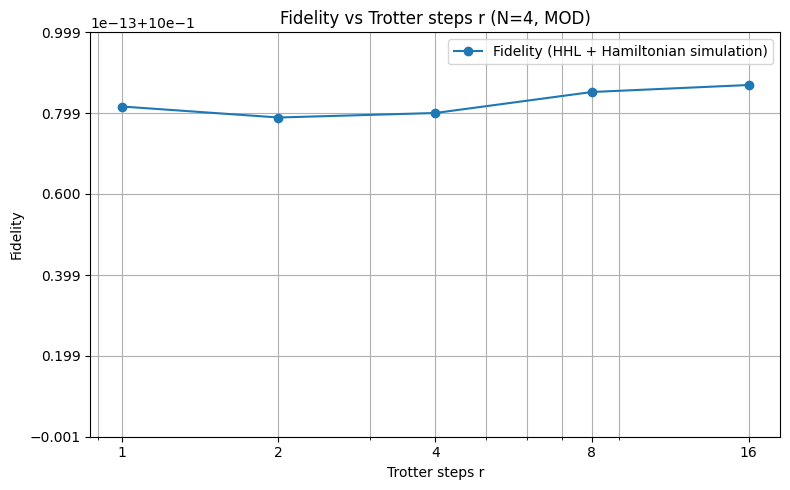

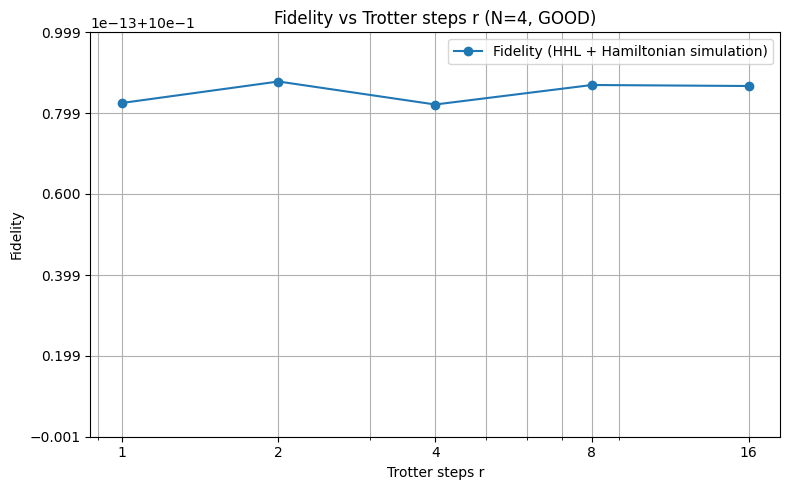

KeyError: 1

In [254]:
for n in [2, 3, 4]:
    for cond in ["MOD", "GOOD"]:
        plot_fidelity(fidelidades[n][cond], r_list, cond, n)

In [253]:
def plot_fidelity(fidelity, r_list, cond, n):
    rs = np.array(r_list, dtype=float)
    ys = [fidelity[r] for r in r_list]

    plt.figure(figsize=(8,5))

    # X log, Y linear (correto para fidelidade)
    plt.semilogx(rs, ys, 'o-', label='Fidelity (HHL + Hamiltonian simulation)')

    plt.xticks([1, 2, 4, 8, 16], ['1', '2', '4', '8', '16'])
    plt.xlabel('Trotter steps r')
    plt.ylabel('Fidelity')

    # Zoom na região de interesse
    plt.ylim(0.9999999999999, 1.0)

    plt.grid(True, which='both')
    plt.legend()
    plt.title(f'Fidelity vs Trotter steps r (N={2**n}, {cond})')

    plt.tight_layout()
    plt.savefig(f'fidelity_{cond}_N{2**n}.png', dpi=200)
    plt.show()


In [210]:
r_list

[1, 2, 4, 8, 16]

In [241]:
plot_fidelity(fidelidades[3]["GOOD"], r_list, cond, n)

KeyError: 1

<Figure size 800x500 with 0 Axes>

In [29]:
print(counts)
print(counts3)

NameError: name 'counts' is not defined

In [ ]:
N = 2**n
plot_histogram([counts, counts3], legend=[r'$e^{-iHt}$', r'$U_{sim}$ (2ª ordem)'], figsize=(10,6))

In [ ]:
fidelity = hellinger_fidelity(counts, counts3)
print(f"Fidelidade entre os resultados: {fidelity:.6f}")

In [76]:
inst = generate_d_sparse_hamiltonian(2, 2, 8) 

c:\Users\lucas\Documents\hamiltonian_simulation\.venv\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [77]:
inst.H

array([[ 7.,  3.,  0.,  0.],
       [ 3.,  7.,  0.,  0.],
       [ 0.,  0., 12.,  7.],
       [ 0.,  0.,  7., 13.]])

In [78]:
inst

DSparseInstance(n=2, d=1, H=array([[ 7.,  3.,  0.,  0.],
       [ 3.,  7.,  0.,  0.],
       [ 0.,  0., 12.,  7.],
       [ 0.,  0.,  7., 13.]]), edges=[(0, 1), (2, 3)], diag=array([ 7.,  7., 12., 13.]), w_max_effective=13)

In [84]:
edges = get_edges(mat)
edges

[(0, 2), (1, 3)]

In [81]:
mat

array([[2, 0, 1, 0],
       [0, 4, 0, 2],
       [1, 0, 2, 0],
       [0, 2, 0, 3]])